### OCP LMDB Dataset Tutorial

This notebook provides an overview of how to create LMDB datasets to be used with the OCP repo. This tutorial is intended for those who wish to use OCP to train on their own datasets. Those interested in just using OCP data need not worry about these steps as they've been automated as part of the download script: https://github.com/Open-Catalyst-Project/ocp/blob/master/scripts/download_data.py.

In [48]:
from ocpmodels.preprocessing import AtomsToGraphs
from ocpmodels.datasets import SinglePointLmdbDataset, TrajectoryLmdbDataset
import ase.io
from ase.build import bulk
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.calculators.emt import EMT
from ase.optimize import BFGS
import matplotlib.pyplot as plt
import lmdb
import pickle
from tqdm import tqdm
import torch
import os
import numpy as np

### Generate toy dataset: Relaxation of CO on Cu

In [49]:
adslab = fcc100("Cu", size=(2, 2, 3))
ads = molecule("CO")
add_adsorbate(adslab, ads, 3, offset=(1, 1))
adslab

Atoms(symbols='Cu12OC', pbc=[True, True, False], cell=[5.105310960166873, 5.105310960166873, 0.0], tags=...)

In [50]:

cons = FixAtoms(indices=[atom.index for atom in adslab if (atom.tag == 3)]) # Fix slab atoms 
# atom.tag is defined as the layers to which they belong
cons

FixAtoms(indices=[0, 1, 2, 3])

In [51]:
adslab.set_constraint(cons)
adslab.center(vacuum=13.0, axis=2)
adslab.set_pbc(True)
adslab.set_calculator(EMT())
dyn = BFGS(adslab, trajectory="CuCO_adslab.traj", logfile=None)
dyn.run(fmax=0, steps=1000) # Force convergence standard, if fmax is zero, MD will run untill max steps

False

In [52]:
raw_data = ase.io.read("CuCO_adslab.traj", ":")
len(raw_data)

1001

In [53]:
# 访问最后一个构型
last_atoms = raw_data[-1]
next_atoms = raw_data[-2]
# 输出能量和力信息
print("Final energy: ", last_atoms.get_potential_energy())
print("Final forces: ", last_atoms.get_forces())
energy_con =  last_atoms.get_potential_energy()-next_atoms.get_potential_energy()
force_con = np.amax(last_atoms.get_forces())-np.amax(next_atoms.get_forces())
print("Energy convergence =", energy_con<1E-6, energy_con)
print("Force  convergence =",energy_con<1E-6, force_con)



Final energy:  3.9683558933957266
Final forces:  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.36074213e-15 -5.34363271e-15  2.39283962e-14]
 [-5.83868958e-15  6.63572387e-15  3.15184348e-15]
 [ 3.21956546e-15 -9.11119460e-16  1.07486245e-14]
 [ 4.45129642e-15 -3.14072045e-15  3.23037921e-15]
 [ 3.95777161e-15  6.61666902e-15 -3.02449038e-15]
 [ 1.52675190e-15 -2.10942375e-15 -1.30936928e-14]
 [-6.10622664e-16  1.42263038e-15 -4.16333634e-15]
 [-2.07201877e-15 -2.45751568e-15 -1.42098044e-14]
 [ 1.74827600e-17 -6.69494842e-18  2.87540597e-14]
 [-2.88397778e-16  6.28837260e-17 -2.37761200e-14]]
Energy convergence = True 0.0
Force  convergence = True 0.0


### Initial Structure to Relaxed Energy/Structure (IS2RE/IS2RS) LMDBs

IS2RE/IS2RS LMDBs utilize the SinglePointLmdb dataset. This dataset expects the data to be contained in a SINGLE LMDB file. In addition to the attributes defined by AtomsToGraph, the following attributes must be added for the IS2RE/IS2RS tasks:

- pos_relaxed: Relaxed adslab positions
- sid: Unique system identifier, arbitrary
- y_init: Initial adslab energy, formerly Data.y
- y_relaxed: Relaxed adslab energy
- tags (optional): 0 - subsurface, 1 - surface, 2 - adsorbate


As a demo, we will use the above generated data to create an IS2R* LMDB file.

#### Initialize AtomsToGraph feature extractor

In [54]:
a2g = AtomsToGraphs(
    max_neigh=50,  # 设置每个原子最多与多少个相邻的原子建立联系。
    radius=6,  # 设置建立相邻原子之间边的最大距离。在此半径内的原子将被视为相邻原子。
    r_energy=True,  # False for test data 设置是否将能量作为节点特征添加到图中，默认为True，表示将能量添加到图中。
    r_forces=True,  # 设置是否将力作为节点特征添加到图中，默认为True，表示将力添加到图中。
    r_distances=False,  # 设置是否将原子之间的距离作为特征添加到图中，默认为False，表示不添加距离特征。
    r_fixed=True,  # 设置是否将固定性作为节点特征添加到图中，默认为True，表示将固定性添加到图中
)

#### Initialize LMDB file

In [55]:
db = lmdb.open(
    "sample_CuCO.lmdb",
    map_size=5 * 1024 * 1024 * 1024,  # 5G
    subdir=False,
    meminit=False,
    map_async=True,
)

#### Write data to LMDB

In [56]:
def read_trajectory_extract_features(a2g, traj_path):
    traj = ase.io.read(traj_path, ":")
    tags = traj[0].get_tags()
    images = [traj[0], traj[-1]]
    data_objects = a2g.convert_all(images, disable_tqdm=True)
    data_objects[0].tags = torch.LongTensor(tags)
    data_objects[1].tags = torch.LongTensor(tags)
    return data_objects

In [57]:
system_paths = ["CuCO_adslab.traj"]
idx = 0 

for system in system_paths:
    # Extract Data object
    data_objects = read_trajectory_extract_features(a2g, system)
    initial_struc = data_objects[0]
    relaxed_struc = data_objects[1]
    
    initial_struc.y_init = initial_struc.y # subtract off reference energy, if applicable
    del initial_struc.y
    initial_struc.y_relaxed = relaxed_struc.y # subtract off reference energy, if applicable
    initial_struc.pos_relaxed = relaxed_struc.pos
    
    # Filter data if necessary
    # OCP filters adsorption energies > |10| eV
    
    initial_struc.sid = idx  # arbitrary unique identifier 
    
    # no neighbor edge case check
    if initial_struc.edge_index.shape[1] == 0:
        print("no neighbors", traj_path)
        continue
    
    # Write to LMDB
    txn = db.begin(write=True)
    txn.put(f"{idx}".encode("ascii"), pickle.dumps(initial_struc, protocol=-1))
    txn.commit()
    db.sync()
    idx += 1

db.close()

In [58]:
dataset = SinglePointLmdbDataset({"src": "sample_CuCO.lmdb"})
len(dataset)
dataset
data0 = dataset[0]
data0

Data(pos=[14, 3], cell=[1, 3, 3], atomic_numbers=[14], natoms=14, tags=[14], edge_index=[2, 636], cell_offsets=[636, 3], force=[14, 3], fixed=[14], y_init=3.989314410668539, y_relaxed=3.9683558933957266, pos_relaxed=[14, 3], sid=0)

In [59]:
dataset[0]
print(dataset)

### Structure to Energy and Forces (S2EF) LMDBs

S2EF LMDBs utilize the TrajectoryLmdb dataset. This dataset expects a directory of LMDB files. In addition to the attributes defined by AtomsToGraph, the following attributes must be added for the S2EF task:

- tags (optional): 0 - subsurface, 1 - surface, 2 - adsorbate
- fid: Frame index along the trajcetory
- sid- sid: Unique system identifier, arbitrary

Additionally, a "length" key must be added to each LMDB file.

As a demo, we will use the above generated data to create an S2EF LMDB dataset

In [60]:
os.makedirs("s2ef", exist_ok=True)
db = lmdb.open(
    "s2ef/sample_CuCO.lmdb",
    map_size=5 * 1024 * 1024 * 1024, 
    subdir=False,
    meminit=False,
    map_async=True,
)

In [61]:
tags = raw_data[0].get_tags()
data_objects = a2g.convert_all(raw_data, disable_tqdm=True)


for fid, data in tqdm(enumerate(data_objects), total=len(data_objects)): # total 用来正确显示进度条的长度
    #assign sid
    data.sid = torch.LongTensor([2]) # 构型的唯一标识符
    #assign fid
    data.fid = torch.LongTensor([fid]) # 历史（帧数）的标识符
    
    #assign tags, if available
    data.tags = torch.LongTensor(tags)
    
    # Filter data if necessary
    # OCP filters adsorption energies > |10| eV and forces > |50| eV/A

    # no neighbor edge case check
    if data.edge_index.shape[1] == 0:
        print("no neighbors", traj_path)
        continue

    txn = db.begin(write=True)
    txn.put(f"{fid}".encode("ascii"), pickle.dumps(data, protocol=-1))
    txn.commit()
    
txn = db.begin(write=True)
txn.put(f"length".encode("ascii"), pickle.dumps(len(data_objects), protocol=-1))
txn.commit()


db.sync()
db.close()

100%|██████████| 1001/1001 [00:01<00:00, 783.90it/s]


In [62]:
dataset = TrajectoryLmdbDataset({"src": "s2ef/"})
len(dataset)

/home/zwbai/miniconda3/envs/ocp-models/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3505: UserWarning: TrajectoryLmdbDataset is deprecated and will be removed in the future.Please use 'LmdbDataset' instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


1001

In [63]:
dataset[0]

Data(pos=[14, 3], cell=[1, 3, 3], atomic_numbers=[14], natoms=14, tags=[14], edge_index=[2, 636], cell_offsets=[636, 3], y=3.989314410668539, force=[14, 3], fixed=[14], sid=[1], fid=[1], id='0_0')

#### Advanced usage

TrajectoryLmdbDataset supports multiple LMDB files because the need to highly parallelize the dataset construction process. With OCP's largest split containing 135M+ frames, the need to parallelize the LMDB generation process for these was necessary. If you find yourself needing to deal with very large datasets we recommend parallelizing this process.

### Interacting with the LMDBs

Below we demonstrate how to interact with an LMDB to extract particular information.

In [73]:
dataset = TrajectoryLmdbDataset({"src": "s2ef/"})
print(dataset)
len(dataset)

1001

In [65]:
data = dataset[0]
data

Data(pos=[14, 3], cell=[1, 3, 3], atomic_numbers=[14], natoms=14, tags=[14], edge_index=[2, 636], cell_offsets=[636, 3], y=3.989314410668539, force=[14, 3], fixed=[14], sid=[1], fid=[1], id='0_0')

In [75]:
energies = torch.tensor([data.y for data in dataset])
print(energies)
len(energies)

tensor([3.9893, 3.9835, 3.9784,  ..., 3.9684, 3.9684, 3.9684])


1001

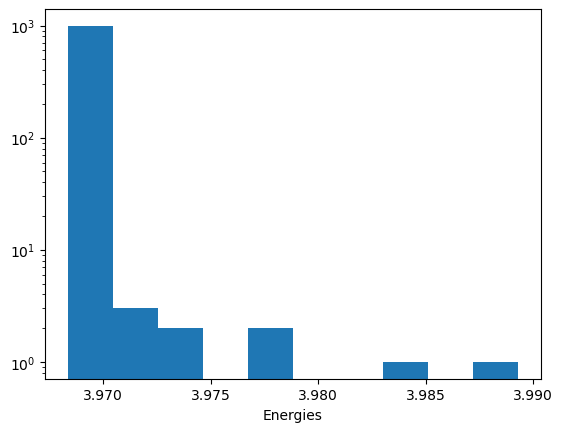

In [67]:
plt.hist(energies, bins = 10)
plt.yscale("log")
plt.xlabel("Energies")
plt.show()